## [Radar trajectories RAMP](http://www.ramp.studio/problems/radar_trajectories): classifying flying objects using radar trajectories



## Introduction

The first goal of a traffic control center is to yield a clear vision of the state of the air traffic. This vision is based on various information about the flying aircrafts, namely radar measurements and other information provided by the planes themselves about their position, as well as some of their characteristics, through the Automatic Dependence Surveillance Broadcast (ADSB) system. To provide air traffic controllers with efficient decision making tools, one should be able to automatically detect a number of features regarding an aircraft, solely based on the radar measurements (that do not depend on whether the aircraft is cooperating or not). In particular, it is desirable to establish whether the aircraft is civilian or military, if its behavior is aggressive or not, what kind of maneuvers it is capable of performing, and which category of airplane it is (helicopter, fighter, liner, drone, etc.). Such information may prove useful for instance to adapt the tracking
algorithm of the radars to the type of aircraft (highly maneuvering aircrafts may require more radar
resource to be tracked), and more generally for decision making supporting tools.

## Type of data used and prediction task

Radar measurements are classified since they contain information about French military operations and trips. Hence, we have collected aircraft trajectories (i.e., position over time) using the publicly available ADSB data. Those trajectories serve as a publicly available alternative to the radar position measurements. The goal of the classification task is to recognize the type of flying objects. There are 19 types, labeled by 4-digit strings: '1111', '1112', '1121', '1122', '1132', '1222', '1224', '1231', '1232', '1233', '1234', '1324', '1332', '1333', '1334', '4111', '4121', '4122', '4222'. Each digit denotes an attribute
1. Species: Kind of aircraft
     - 1 = Airplane - Liner
     - 4 = Helicopter
2. WTC: Wake Turbulence Category
     - 1 = Light
     - 2 = Middle
     - 3 = Heavy
3. EngType: Kind of engine
     - 1 = Piston
     - 2 = Turboprop
     - 3 = Jet
4. Engines: Number of engines

The models will be evaluated by cross entropy a.k.a negative log likelihood (NLL)
$$
- \frac{1}{19} \sum_{i=1}^{19} \log \hat{p}_i
$$
where $\hat{p}_i$ is the predicted probability of the $i$th class given the input (radar trajectories, see below). Besides this official score, we will also display the accuracy (number of correctly classified types divided by the size of the test set) which is more human readable. The NLL score has the advantage that it incentivizes you to come up with unbiased probability estimates which can then be aggregated across aircraft types if we change the task (e.g., to predict the number of engines). 


### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.18
* ramp-workflow

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
from subprocess import check_output

#import arff
#arff.dump('filename.arff', df_global.values, relation='relation_name', names=df_global.columns)

In [17]:
"""Download data after cloning.

Run this once. It will create `data` and download the `train.pkl` and
`test.pkl` there.
"""

import os
import shutil
from subprocess import call

if os.path.exists('data'):
    shutil.rmtree('data')
os.mkdir('data')

url = 'https://storage.ramp.studio/radar_trajectories'
f_names = ['train.pkl', 'test.pkl']
for f_name in f_names:
    url_in = '{}/{}'.format(url, f_name)
    f_name_out = os.path.join('data', f_name)
    cmd = 'wget {} --output-document={} --no-check-certificate'.format(
        url_in, f_name_out)
    call(cmd, shell=True)

In [19]:
url = 'https://storage.ramp.studio/radar_trajectories'
f_names = ['train.pkl', 'test.pkl']
for f_name in f_names:
    url_in = '{}/{}'.format(url, f_name)
    f_name_out = os.path.join('data', f_name)
    cmd = 'wget {} --output-document={} --no-check-certificate'.format(
        url_in, f_name_out)
    call(cmd, shell=True)

# 0. Exploratory data analysis

Let's first import the `problem.py` script which has data reader routines.

In [4]:
#import pip
#import sys
#!{sys.executable} -m pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master
#!pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master

In [7]:
import imp
module_name = str(int(1000000000 * np.random.rand()))
problem = imp.load_source('', 'problem.py')

Let's read the training data and labels from `data/train.pkl` into a pandas dataframe.

In [8]:
#################
### load data ###
#################

X_df, y_array = problem.get_train_data()
X_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '.\\data\\train.pkl'

In [5]:
y_array[:6]

array(['1334', '1334', '1334', '1334', '1334', '1334'], dtype=object)

The training data has two columns. `trajectory_id` is the id of the long trajectory from which we sampled 1000 consecutive trajectory points at random starting times. To have enough training data, we took 10 (possibly overlapping) samples from each long trajectory. The trajectory itself is found in the `data` column. Each instance is represented by a 2D numpy array where each column is a trajectory feature and each row is a time point. Let us convert a single instance into a pandas table to visualize it. 

In [6]:
columns = [
    'T', 'X', 'Vx', 'Ax', 'Jx', 'Y', 'Vy','Ay', 'Jy',
    'Z', 'Vz', 'Az', 'Jz', 'U2', 'C2', 'U3', 'C3', 'T3']
i = 0
trajectory_df = pd.DataFrame(X_df['data'][i], columns=columns)
trajectory_df.head()

,T,X,Vx,Ax,Jx,Y,Vy,Ay,Jy,Z,Vz,Az,Jz,U2,C2,U3,C3,T3
0,687.2,-42505.811394,-186.445530,0.527593,-0.348581,18928.938827,139.989477,-0.134908,0.209719,9792.043490,4.416229,0.090406,-0.036061,233.150143,-1.648263e-08,233.191965,0.000004,0.000398
1,687.3,-42524.436092,-186.325593,0.491766,-0.351540,18942.934472,139.966507,-0.113787,0.210171,9792.486687,4.429595,0.086736,-0.036254,233.040447,-1.614911e-08,233.082542,0.000004,0.000411
2,687.4,-42543.049728,-186.214235,0.455664,-0.354288,18956.928870,139.949632,-0.092672,0.210452,9792.931193,4.442419,0.083047,-0.036441,232.941282,-1.579758e-08,232.983639,0.000004,0.000425
3,687.5,-42561.653219,-186.111516,0.419317,-0.356824,18970.922696,139.938867,-0.071586,0.210562,9793.376952,4.454704,0.079338,-0.036620,232.852707,-1.542795e-08,232.895314,0.000004,0.000441
4,687.6,-42580.247497,-186.017491,0.382753,-0.359145,18984.916631,139.934225,-0.050553,0.210499,9793.823911,4.466447,0.075611,-0.036792,232.774772,-1.504015e-08,232.817618,0.000004,0.000460


Here is the meaning of the columns:
- `T`: time
- `X`, `Vx`, `Ax`, `Jx`: X coordinate of the resp. position, velocity, acceleration, and jerk (i.e. first to third order derivative) of the aircraft
- `Y`, `Vy`, `Ay`, `Jy`: Y coordinate of the resp. position, velocity,  acceleration, and jerk (i.e. first to third order derivative) of the aircraft
- `Z`, `Vz`, `Az`, `Jz`: Z coordinate of the resp. position, velocity,  acceleration, and jerk (i.e. first to third order derivative) of the aircraft
- `U2`: absolute value of velocity vector projected onto the ground plane
- `C3`: curvature of the 3D trajectory: $\frac{||P'\times P''||}{||P'||^3}$ where $P = (X, Y, Z)$
- `T3`: torsion of the 3D trajectory: $\frac{\det(P',P'',P''')}{||P'\times P''||^2}$
- `C2`: curvature of the trajectory projected onto the ground plane: $\frac{||\tilde P'\times \tilde
P''||}{||\tilde P'||^3}$ where $\tilde P=(X,Y,0)$
- `U3`: absolute value of the 3D velocity vector


# 1. Feature engineering

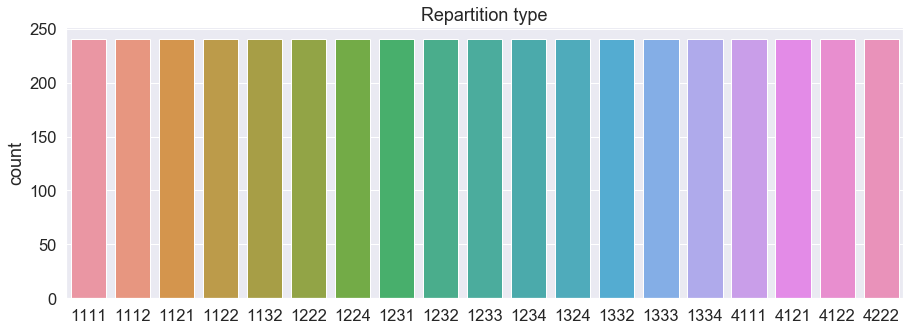

In [7]:
sns.set(style="darkgrid", font_scale=1.5)
plt.figure(figsize=(15,5))
plt.title('Repartition type')
ax = sns.countplot(y_array)

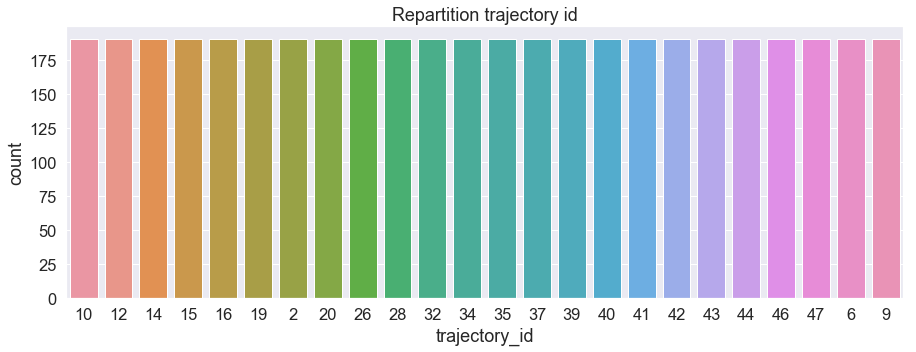

In [8]:
plt.figure(figsize=(15,5))
plt.title('Repartition trajectory id')
ax = sns.countplot(X_df.trajectory_id)

Data are equitably distributed. Because (we can and) we are fan of Pandas let's go for it! Not time for efficiency (for now)... Here we creat a fancy DataFrame:

In [9]:
####################
### new data set ###
####################

columns = ['T', 'X', 'Vx', 'Ax', 'Jx', 'Y', 'Vy','Ay', 'Jy', 'Z', 'Vz', 'Az', 'Jz', 'U2', 'C2', 'U3', 'C3', 'T3', 'id']
number_data_per_object = len(X_df['data'][0])
data = np.zeros((len(X_df) * number_data_per_object, len(columns)))
for i in range(len(X_df)):
    data[i * number_data_per_object:(i + 1) * number_data_per_object, :18] = X_df['data'][i]
    data[i * number_data_per_object:(i + 1) * number_data_per_object, -1] = np.repeat(i, number_data_per_object)
df = pd.DataFrame(data=data, columns=columns)
df['type'] = np.repeat(y_array, number_data_per_object)
df.head(5)

,T,X,Vx,Ax,Jx,Y,Vy,Ay,Jy,Z,Vz,Az,Jz,U2,C2,U3,C3,T3,id,type
0,687.2,-42505.811394,-186.445530,0.527593,-0.348581,18928.938827,139.989477,-0.134908,0.209719,9792.043490,4.416229,0.090406,-0.036061,233.150143,-1.648263e-08,233.191965,0.000004,0.000398,0.0,1334
1,687.3,-42524.436092,-186.325593,0.491766,-0.351540,18942.934472,139.966507,-0.113787,0.210171,9792.486687,4.429595,0.086736,-0.036254,233.040447,-1.614911e-08,233.082542,0.000004,0.000411,0.0,1334
2,687.4,-42543.049728,-186.214235,0.455664,-0.354288,18956.928870,139.949632,-0.092672,0.210452,9792.931193,4.442419,0.083047,-0.036441,232.941282,-1.579758e-08,232.983639,0.000004,0.000425,0.0,1334
3,687.5,-42561.653219,-186.111516,0.419317,-0.356824,18970.922696,139.938867,-0.071586,0.210562,9793.376952,4.454704,0.079338,-0.036620,232.852707,-1.542795e-08,232.895314,0.000004,0.000441,0.0,1334
4,687.6,-42580.247497,-186.017491,0.382753,-0.359145,18984.916631,139.934225,-0.050553,0.210499,9793.823911,4.466447,0.075611,-0.036792,232.774772,-1.504015e-08,232.817618,0.000004,0.000460,0.0,1334


So we know the meaning of '1334', '4122', etc. so why not convert it in a more understanding way? Let's do it:

In [10]:
#######################
### matrix for name ###
#######################

matrix_corresponding_name = np.array([['', 'Airplane', '', '', 'Helicopter'],
                                      ['', 'Light', 'Middle', 'Heavy', ''],
                                      ['', 'Piston', 'Turboprop', 'Jet', ''],
                                      ['', '1', '2', '3', '4']])
#########################
### new specie column ###
#########################

specie = []
for type_temp in y_array:
    specie.append(matrix_corresponding_name[0, int(type_temp[0])] + '-' \
                  + matrix_corresponding_name[1, int(type_temp[1])] + '-' \
                  + matrix_corresponding_name[2, int(type_temp[2])] + '-' \
                  + type_temp[3])

######################
### add new column ###
######################

df['specie'] = np.repeat(specie, 1000)
df.head(5)

,T,X,Vx,Ax,Jx,Y,Vy,Ay,Jy,Z,...,Az,Jz,U2,C2,U3,C3,T3,id,type,specie
0,687.2,-42505.811394,-186.445530,0.527593,-0.348581,18928.938827,139.989477,-0.134908,0.209719,9792.043490,...,0.090406,-0.036061,233.150143,-1.648263e-08,233.191965,0.000004,0.000398,0.0,1334,Airplane-Heavy-Jet-4
1,687.3,-42524.436092,-186.325593,0.491766,-0.351540,18942.934472,139.966507,-0.113787,0.210171,9792.486687,...,0.086736,-0.036254,233.040447,-1.614911e-08,233.082542,0.000004,0.000411,0.0,1334,Airplane-Heavy-Jet-4
2,687.4,-42543.049728,-186.214235,0.455664,-0.354288,18956.928870,139.949632,-0.092672,0.210452,9792.931193,...,0.083047,-0.036441,232.941282,-1.579758e-08,232.983639,0.000004,0.000425,0.0,1334,Airplane-Heavy-Jet-4
3,687.5,-42561.653219,-186.111516,0.419317,-0.356824,18970.922696,139.938867,-0.071586,0.210562,9793.376952,...,0.079338,-0.036620,232.852707,-1.542795e-08,232.895314,0.000004,0.000441,0.0,1334,Airplane-Heavy-Jet-4
4,687.6,-42580.247497,-186.017491,0.382753,-0.359145,18984.916631,139.934225,-0.050553,0.210499,9793.823911,...,0.075611,-0.036792,232.774772,-1.504015e-08,232.817618,0.000004,0.000460,0.0,1334,Airplane-Heavy-Jet-4


Ok so now that we have a nice DataFrame we will try to figure out which features are importante at this point. We first run a PCA analysis and run a SelectKBest.

## 1.1 PCA analysis and feature selection

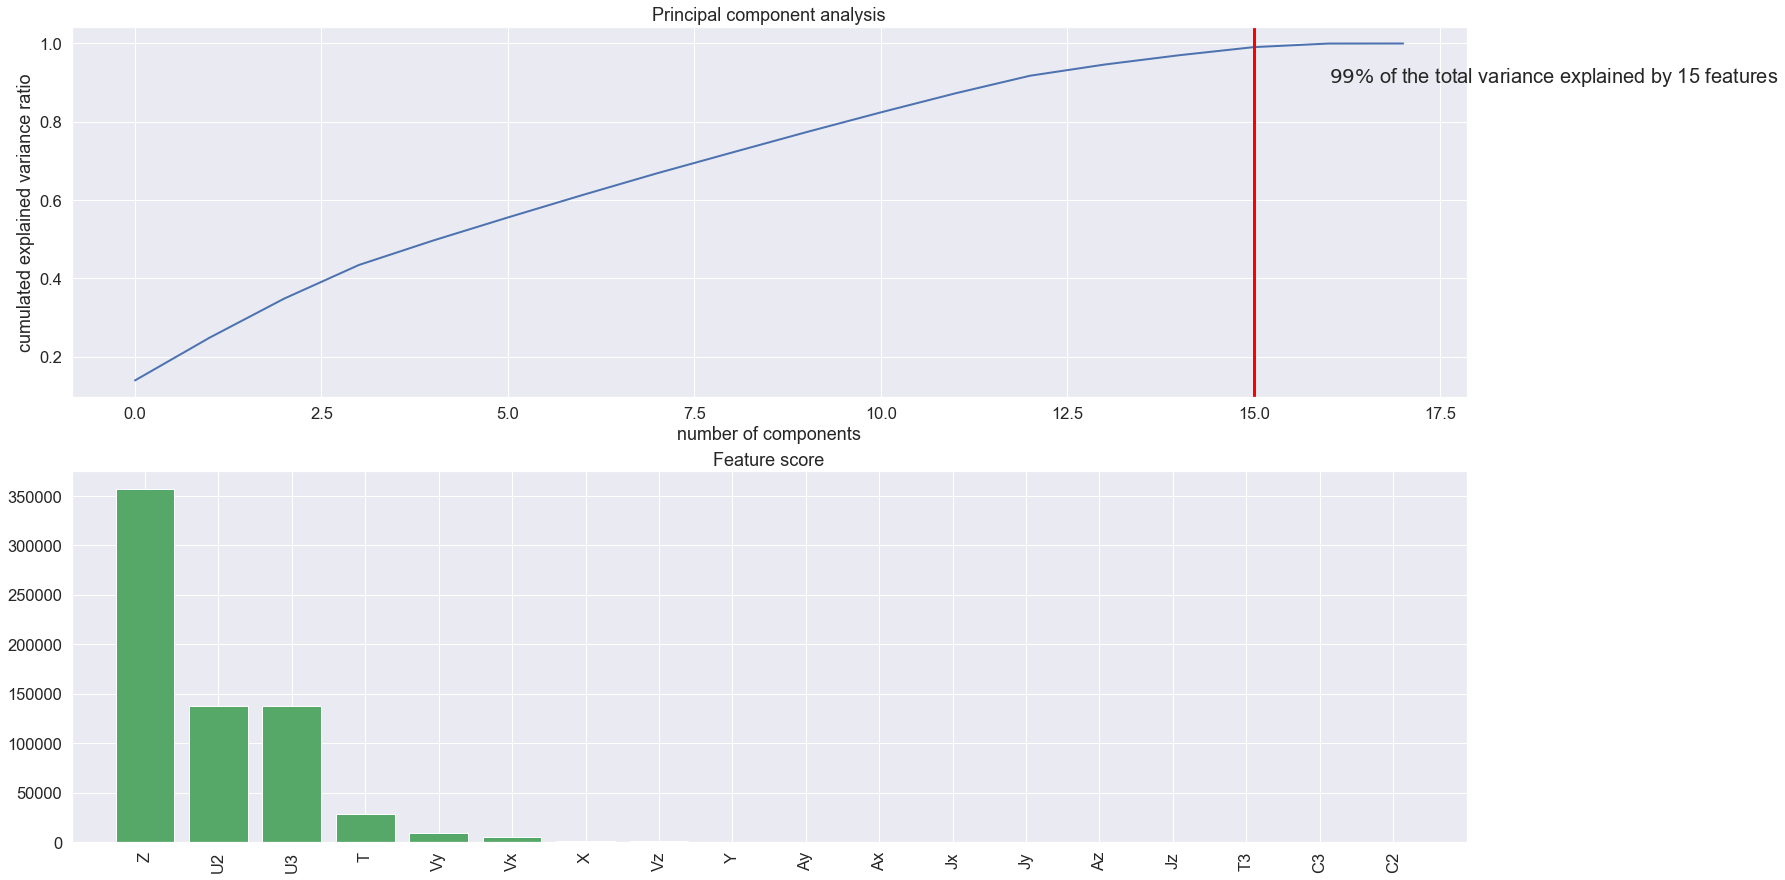

In [12]:
########################
### import libraries ###
########################

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

################################
### split train/test dataset ###
################################

scaler = StandardScaler() # normalization for PCA
scaler.fit(df.drop(['specie', 'id', 'type'], axis=1))
x_train, y_train = scaler.transform(df.drop(['specie', 'id', 'type'], axis=1)), df.specie


####################
### PCA analysis ###
####################

pca = PCA()
pca.fit(x_train)

####################
### plotting PCA ###
####################

plt.figure(figsize=(25, 15))
plt.subplot(2,1,1)
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
index_99_pca = list(np.cumsum(pca.explained_variance_ratio_) > 0.99).index(True)
plt.axvline(x=index_99_pca, color='red', linewidth=3)
plt.text(index_99_pca + 1, 0.90, r'$99\%$ of the total variance explained by ' + str(index_99_pca) + ' features', fontsize=20)
plt.title('Principal component analysis')
plt.xlabel('number of components')
plt.ylabel('cumulated explained variance ratio')

###################
### SelectKBest ###
###################

x_train = df.drop(['specie', 'id', 'type'], axis=1)
select_feature = SelectKBest(f_classif, k=index_99_pca).fit(x_train, y_train)

############################
### plotting SelectKBest ###
############################

importances = select_feature.scores_
indices = np.argsort(importances)[::-1]
plt.subplot(2,1,2)
plt.title("Feature score")
plt.bar(range(df.drop(['specie', 'id', 'type'], axis=1).shape[1]), importances[indices],
       color="g", align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])

plt.show()

PCA reveals that with 15 classic features we can explained 99% of the total variance. We will add more features and run the same analysis:

In [230]:
from scipy.stats import hmean
from scipy.stats.mstats import gmean
####################################
### select all meaningfull index ###
####################################

liste_parameters = range(18)
T, X, Vx, Ax, Jx, Y, Vy, Ay, Jy, Z, Vz, Az, Jz, U2, C2, U3, C3, T3 = range(18)
nb_row, nb_col = np.shape(X_df)

################
### new data ###
################

                #######################
                ### global features ###
                #######################

data_matrix = np.asarray(list(X_df['data'].values))
minimum = np.min(data_matrix[:, :, liste_parameters], axis=1)
maximum = np.max(data_matrix[:, :, liste_parameters], axis=1)
median = np.median(data_matrix[:, :, liste_parameters], axis=1)
quantile_25 = np.percentile(data_matrix[:, :, liste_parameters], q=25, axis=1)
quantile_75 = np.percentile(data_matrix[:, :, liste_parameters], q=75, axis=1)
total_sum = np.sum(data_matrix[:, :, liste_parameters], axis=1)
std = np.std(data_matrix[:, :, liste_parameters], axis=1)
geo_mean = gmean(abs(data_matrix[:, :, liste_parameters]) + 1, axis=1)
har_mean = hmean(abs(data_matrix[:, :, liste_parameters]) + 1, axis=1)

                ########################
                ### special features ###
                ########################
            
dist_2d = (data_matrix[:, 0, X] - data_matrix[:, -1, X]) ** 2 + (data_matrix[:, 0, Y] - data_matrix[:, -1, Y]) ** 2
norm_loc = np.linalg.norm(data_matrix[:, :, X] + data_matrix[:, :, Y] + data_matrix[:, :, Z], axis=1)
norm_speed = np.linalg.norm(data_matrix[:, :, Vx] + data_matrix[:, :, Vy] + data_matrix[:, :, Vz], axis=1)
norm_acc = np.linalg.norm(data_matrix[:, :, Ax] + data_matrix[:, :, Ay] + data_matrix[:, :, Az], axis=1)
norm_jig = np.linalg.norm(data_matrix[:, :, Jx] + data_matrix[:, :, Jy] + data_matrix[:, :, Jz], axis=1)
data_temp = np.sqrt((np.diff(data_matrix[:, :, X]) ** 2\
                     + np.diff(data_matrix[:, :, Y]) ** 2 + np.diff(data_matrix[:, :, Z]) ** 2)) / 0.1 # cheat a bit
mean_speed = np.mean(data_temp, axis=1) 
std_speed = np.std(data_temp, axis=1)
min_speed = np.min(data_temp, axis=1)
max_speed = np.max(data_temp, axis=1)

data_temp = np.sqrt((np.diff(data_matrix[:, :, Vx]) ** 2\
                     + np.diff(data_matrix[:, :, Vy]) ** 2 + np.diff(data_matrix[:, :, Vz]) ** 2)) / 0.1 # cheat a bit
mean_acc = np.mean(data_temp, axis=1) 
std_acc = np.std(data_temp, axis=1)
min_acc = np.min(data_temp, axis=1)
max_acc = np.max(data_temp, axis=1)

data_temp = np.diff(data_matrix[:, :, X], axis=1) ** 2 + np.diff(data_matrix[:, :, Y], axis=1) ** 2
pitch = np.cos(np.sqrt((data_temp / (data_temp + np.diff(data_matrix[:, :, Z], axis=1) ** 2))))
pitch_mean = np.mean(pitch, axis=1)

data_temp = np.diff(data_matrix[:, :, X], axis=1) ** 2
angle_1 = np.cos(np.sqrt((data_temp / (data_temp + np.diff(data_matrix[:, :, Y], axis=1) ** 2))))
angle_1_mean = np.mean(pitch, axis=1)

data_temp = np.diff(data_matrix[:, :, X], axis=1) ** 2
angle_2 = np.cos(np.sqrt((data_temp / (data_temp + np.diff(data_matrix[:, :, Z], axis=1) ** 2))))
angle_2_mean = np.mean(pitch, axis=1)

data_temp = np.diff(data_matrix[:, :, Y], axis=1) ** 2
angle_3 = np.cos(np.sqrt((data_temp / (data_temp + np.diff(data_matrix[:, :, Z], axis=1) ** 2))))
angle_3_mean = np.mean(pitch, axis=1)

                    ###############
                    ### dataset ###
                    ###############

global_data = np.concatenate([minimum, maximum, median, quantile_25, quantile_75, total_sum, std, geo_mean, har_mean,
                              dist_2d.reshape(nb_row, 1), norm_speed.reshape(nb_row, 1),
                              norm_acc.reshape(nb_row, 1), norm_jig.reshape(nb_row, 1),
                              norm_loc.reshape(nb_row, 1), mean_speed.reshape(nb_row, 1),
                              std_speed.reshape(nb_row, 1), min_speed.reshape(nb_row, 1),
                              max_speed.reshape(nb_row, 1), pitch_mean.reshape(nb_row, 1),
                              angle_1_mean.reshape(nb_row, 1), angle_2_mean.reshape(nb_row, 1),
                              angle_3_mean.reshape(nb_row, 1), mean_acc.reshape(nb_row, 1),
                              std_acc.reshape(nb_row, 1), min_acc.reshape(nb_row, 1),
                              max_acc.reshape(nb_row, 1)], axis=1)

###################
### new columns ###
###################

list_to_compute = ['_min', '_max', '_median','_25', '_75', '_sum', '_std', '_geo_mean', '_har_mean']
list_paramaters_str = ['T', 'X', 'Vx', 'Ax', 'Jx', 'Y', 'Vy', 'Ay', 'Jy', 'Z', 'Vz', 'Az', 'Jz', 'U2', 'C2', 'U3', 'C3', 'T3']
column_global_features = np.core.defchararray.add(np.array([list_paramaters_str,] * len(list_to_compute)),
                                 np.array([list_to_compute,] * len(list_paramaters_str)).transpose())
column_global_features = column_global_features.flatten()
column_global_features = np.append(column_global_features, ['dist_2d', 'norm_speed', 'norm_acc', 'norm_jig', 'norm_loc',
                                                           'mean_speed', 'std_speed', 'min_speed', 'max_speed',
                                                           'pitch_mean', 'angle_2_mean', 'angle_3_mean', 'angle_1_mean',
                                                            'mean_acc', 'std_acc', 'min_acc', 'max_acc'])

#####################
### new DataFrame ###
#####################

df_global = pd.DataFrame(data=global_data, columns=column_global_features)
df_global['specie'] = specie
df_global.head(5)

,T_min,X_min,Vx_min,Ax_min,Jx_min,Y_min,Vy_min,Ay_min,Jy_min,Z_min,...,max_speed,pitch_mean,angle_2_mean,angle_3_mean,angle_1_mean,mean_acc,std_acc,min_acc,max_acc,specie
0,687.2,-62527.858191,-224.261944,-2.826592,-0.529887,18928.938827,136.974643,-0.898106,-0.329351,9792.043490,...,340.749557,0.540391,0.540391,0.540391,0.540391,2.265517,2.439979,0.073748,31.376765,Airplane-Heavy-Jet-4
1,663.6,-57834.014593,-224.261944,-2.826592,-0.529887,15400.291630,136.974643,-0.959682,-0.329351,9759.522731,...,340.749557,0.540398,0.540398,0.540398,0.540398,2.694248,2.417636,0.198782,31.376765,Airplane-Heavy-Jet-4
2,514.3,-27839.211087,-233.285806,-1.615660,-0.611403,-6950.855533,132.498551,-1.896406,-0.658505,9751.339885,...,312.097135,0.540351,0.540351,0.540351,0.540351,2.821487,2.755577,0.139149,36.435678,Airplane-Heavy-Jet-4
3,650.3,-55167.854894,-224.261944,-2.826592,-0.529887,13343.082543,136.974643,-1.166447,-0.550838,9759.522731,...,340.749557,0.540398,0.540398,0.540398,0.540398,2.967229,2.495023,0.198782,31.376765,Airplane-Heavy-Jet-4
4,530.3,-30936.656569,-214.806720,-1.645903,-0.429666,-4515.181030,135.128967,-1.282984,-0.396553,9751.339885,...,312.477520,0.540351,0.540351,0.540351,0.540351,2.665976,2.290312,0.176659,26.624319,Airplane-Heavy-Jet-4


Now we redo the PCA analysis

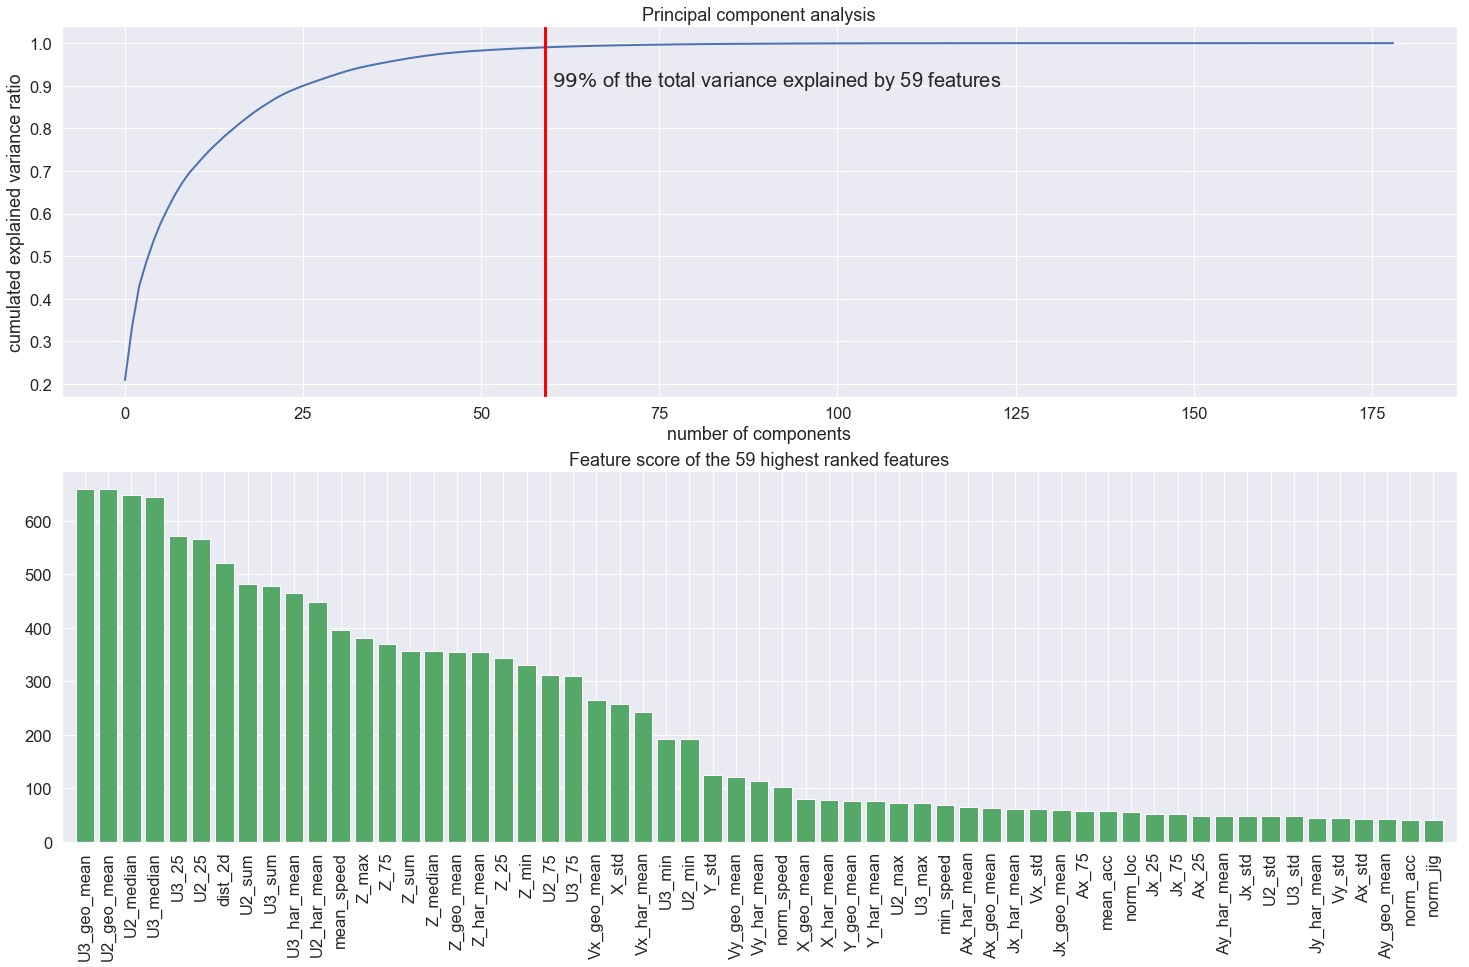

In [123]:
from sklearn.preprocessing import StandardScaler

################################
### split train/test dataset ### 
################################

scaler = StandardScaler() # normalization for PCA
scaler.fit(df_global.drop(['specie'], axis=1))
x_train, y_train = scaler.transform(df_global.drop(['specie'], axis=1)), df_global.specie

####################
### PCA analysis ###
####################

pca = PCA()
pca.fit(x_train)

####################
### plotting PCA ###
####################

plt.figure(figsize=(25, 15))
plt.subplot(2,1,1)
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
index_99_pca = list(np.cumsum(pca.explained_variance_ratio_) > 0.99).index(True)
plt.axvline(x=index_99_pca, color='red', linewidth=3)
plt.text(index_99_pca + 1, 0.90, r'$99\%$ of the total variance explained by ' + str(index_99_pca) + ' features', fontsize=20)
plt.title('Principal component analysis')
plt.xlabel('number of components')
plt.ylabel('cumulated explained variance ratio')

###################
### SelectKBest ###
###################
x_train = df_global.drop(['specie'], axis=1)

select_feature = SelectKBest(f_classif, k=index_99_pca).fit(x_train, y_train) # change k according to PCA 

############################
### plotting SelectKBest ###
############################

importances = select_feature.scores_
indices = np.argsort(importances)[::-1]
plt.subplot(2,1,2)
plt.title("Feature score of the " + str(index_99_pca) + " highest ranked features") 
plt.bar(range(index_99_pca), importances[indices][:index_99_pca], color="g", align="center")
plt.xticks(range(index_99_pca), x_train.columns[indices][:index_99_pca], rotation=90)
best_feature = x_train.columns[indices][:index_99_pca]
plt.xlim([-1, index_99_pca])

plt.show()

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=141, n_estimators=300, max_depth=None)
selector = RFECV(estimator, step=2, cv=3)
selector = selector.fit(df_global.drop(['specie'], axis=1), df_global['specie'])
dict_features =  {'median':[], '25': [], 'special': [], '75' :[], 'min':[], 'max':[], 'std':[], 'sum':[]}
for i in df_global.drop(['specie'], axis=1).columns[selector.support_]:
    if i.split('_')[-1] in dict_features.keys():
        dict_features[i.split('_')[-1]].append(i.split('_')[0])
    else:
        dict_features['special'].append(i)
print(dict_features)

## 1.2 Classification

We creat a function that will perform a grid search to tune model's parameters and then print some informations (accuracy, confusion matrix). All this to class/rank different classification method.

In [272]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import GridSearchCV
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

def tune_plot(model, param, X, y, normalize=1, iter_gridsearch=1, nb_cv=5, test_size=0.3, seed=141421):
    
    """
    Tune a given model with GridSearchCV and give for accuracy results with a confusion matrix.
    
    First you need to make sure that you imported the library for your model!
    
    model = classificator
    param = parameters of your classificator that you want to tune 
    X = data for prediction (DataFrame pref)
    y = target to predict (DataFrame pref)
    normalize = True/False (normalize both X and y with StandardScaler and LabelEncoder)
    iter_gridsearch = number of iteration for GridSearchCV (can be usefull if your model involve randomness)
    nb_cv = number of cross validation
    test_size = test size in percent (splitting train and test set)
    seed = seed for random state
    """
    
    print(" ******************************* ", str(model), " ******************************* ")
    
    ######################
    ### Normalize data ###
    ######################
    
    if normalize:
        le = LabelEncoder()
        le.fit(y)
        yy = le.transform(y)

        scaler = StandardScaler()
        scaler.fit(X)
        XX = scaler.transform(X)
    else:
        yy = y
        XX = X
    
    ####################
    ### GridSearchCV ###
    ####################
    
    if iter_gridsearch > 1:
        keys = param.keys()
        dic_result = {key: [] for key in keys}
        for i in tqdm(range(iter_gridsearch)):
            clf = model()
            result_grid_search = GridSearchCV(estimator=clf, param_grid=param, cv=nb_cv)
            result_grid_search.fit(XX, yy)
            for key in keys:
                dic_result[key].append(result_grid_search.best_params_[key])
        best_param = {}
        for key in keys:
            track = {}
            for item in dic_result[key]: 
                if item not in track:
                    track[item] = 0
                else:
                    track[item] += 1
            best_param[key] = max(track, key=track.get)
    else:
        clf = model()
        result_grid_search = GridSearchCV(estimator=clf, param_grid=param, cv=nb_cv)
        result_grid_search.fit(XX, yy)
        best_param = result_grid_search.best_params_
    
    print('best parameters: ', best_param)
    
    ####################
    ### update model ###
    ####################
    
    clf = model(**best_param)
    
    ########################
    ### train / test set ###
    ########################
    
    x_train, x_test, y_train, y_test = train_test_split(XX, yy, test_size=test_size, random_state=seed)
    
    #################
    ### fit model ###
    #################    
    
    clf.fit(x_train, y_train)
    
    ########################
    ### Cross validation ###
    ########################

    print('Average cross validation: ' + str(np.mean(cross_val_score(clf, XX, yy, cv=nb_cv))))
    print('Accuracy is: ', accuracy_score(y_test, clf.predict(x_test)))
    
    #####################################
    ### plotting the confusion matrix ###
    #####################################

    title='Confusion matrix'
    plt.figure(figsize=(25,10))
    cm = confusion_matrix(y_test, clf.predict(x_test))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    classes = y.unique() # care here always y not yy!
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


best parameters:  {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 1, 'metric': 'manhattan'}
Average cross validation: 0.7042300135147392
Accuracy is:  0.7668128654970761


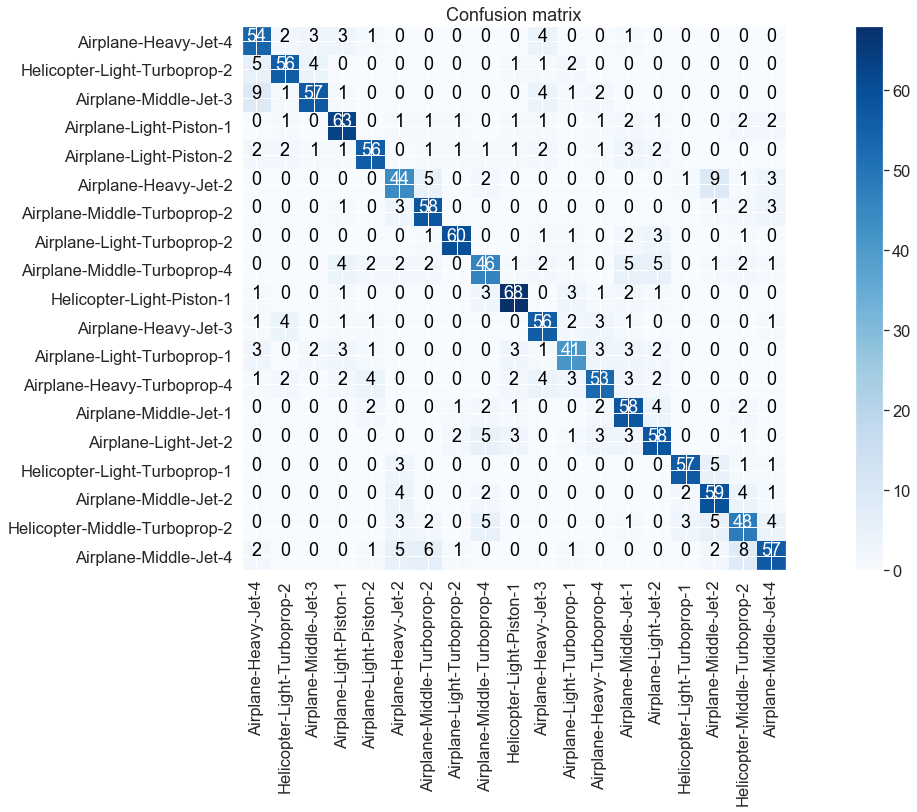

In [241]:
param = {
        'n_neighbors': [1],
        'weights': ['uniform'],
        'algorithm': ['ball_tree'],
        'leaf_size': [1],
        'metric': ['manhattan']
        }

tune_plot(KNeighborsClassifier, param,
          df_global[best_feature], df_global.specie, normalize=1,
          iter_gridsearch=5, nb_cv=5, test_size=0.3, seed=141421)

best parameters:  {'learning_rate': 0.1, 'n_estimators': 200, 'objective': 'multi:softprob'}
Average cross validation: 0.6409486691531986
Accuracy is:  0.6973684210526315


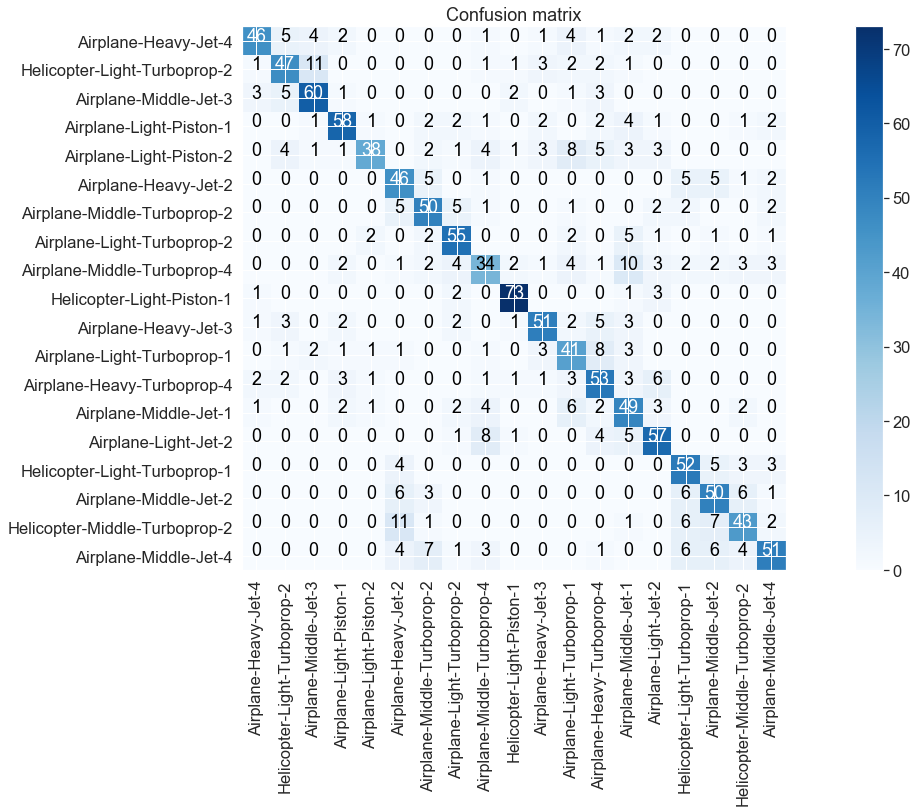

In [259]:
param = {
        'n_estimators': [100, 200],
        'learning_rate' : [0.1],
        'objective': ['multi:softprob']
        }

tune_plot(XGBClassifier, param,
          df_global[best_feature], df_global.specie, normalize=1,
          iter_gridsearch=1, nb_cv=5, test_size=0.3, seed=141421)

 ********************************  <class 'sklearn.ensemble.forest.RandomForestClassifier'>  ******************************** 
best parameters:  {'max_depth': 20, 'n_estimators': 200}
Average cross validation: 0.3335526315789473
Accuracy is:  0.7653508771929824


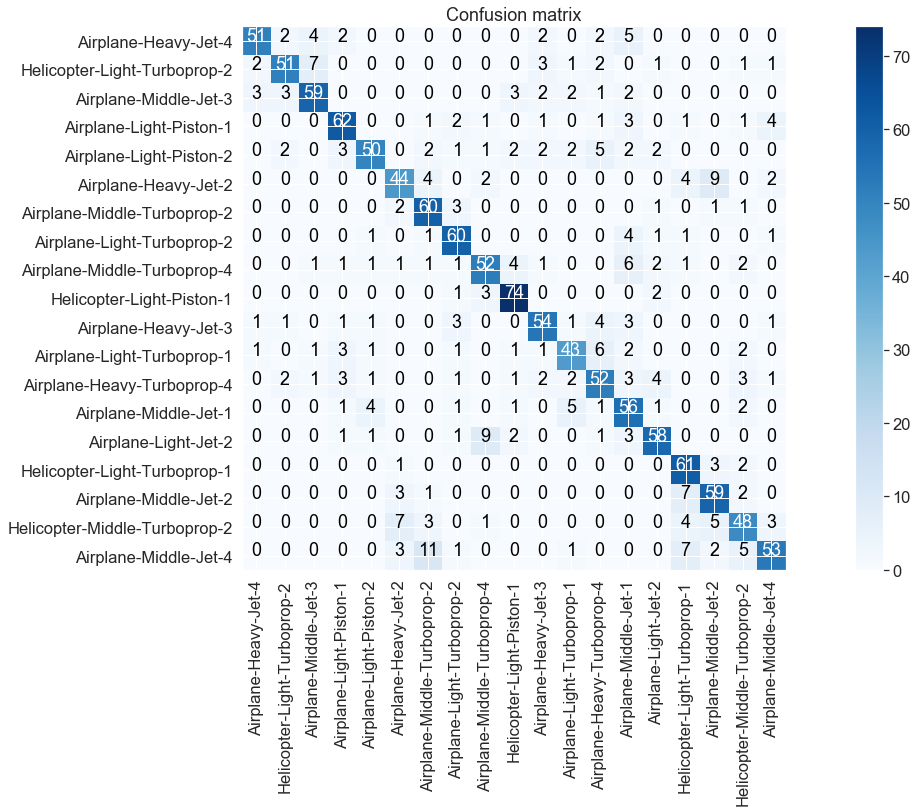

In [271]:
param = {
        'n_estimators': [100, 200],
        'max_depth' : [10, 20],
        }

tune_plot(RandomForestClassifier, param,
          df_global[best_feature], df_global.specie, normalize=1,
          iter_gridsearch=1, nb_cv=5, test_size=0.3, seed=141421)

In [ ]:
param = { 
         'C' : [300, 400, 500, 600, 700, 800, 900, 1000], # 1 is default
         'gamma' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], # 'auto' is default
         'kernel' : ['rbf'] # 'rbf' is default
         }

tune_plot(SVC, param,
          df_global[best_feature], df_global.specie, normalize=1,
          iter_gridsearch=1, nb_cv=5, test_size=0.3, seed=141421)

 *******************************  <class 'sklearn.svm.classes.SVC'>  ******************************* 


# 2. The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in two different files:   
* the class `FeatureExtractor`, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples $\times$ number of features). 
* a class `Classifier` to predict aircraft type

### Feature extractor

The feature extractor implements a `transform` member function. It is saved in the file [`submissions/starting_kit/feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py). It receives the pandas dataframe `X_df` defined at the beginning of the notebook. It should produce a numpy array representing the extracted features, which will then be used for the classification. The following simple feature extractor simply computes the mean of each feature and produces an 18 dimensional feature vector for each trajectory.

In [77]:
import numpy as np
from scipy.stats import hmean
from scipy.stats.mstats import gmean

class FeatureExtractor():
    def __init__(self):
        pass

    # use this if you need to learn something at training time that depends on the labels
    # this will not be called on the test instances
    def fit(self, X_df, y):
        pass

    # this will be called both on the training and test instance
    def transform(self, X_df):
        T, X, Vx, Ax, Jx, Y, Vy, Ay, Jy, Z, Vz, Az, Jz, U2, C2, U3, C3, T3 = range(18)
        liste_parameters = range(18)
        nb_row, nb_col = np.shape(X_df)
        
        data_matrix = np.asarray(list(X_df['data'].values))
        minimum = np.min(data_matrix[:, :, [T, X, Vx, Ax, Jx, Y, Vy, Ay, Jy, Z, Vz, Az, Jz, U2, C2, U3, T3]], axis=1)
        maximum = np.max(data_matrix[:, :, [T, X, Vx, Ax, Jx, Y, Vy, Ay, Jy, Z, Vz, Az, Jz, U2, C2, U3, C3, T3]], axis=1)
        median = np.median(data_matrix[:, :, [T, X, Vx, Ax, Jx, Y, Vy, Ay, Jy, Z,Vz, U2, U3, C3]], axis=1)
        quantile_25 = np.percentile(data_matrix[:, :, [T, X, Vx, Ax, Jx, Y, Vy, Ay, Jy, Z, Vz, Az, Jz, U2, U3, C3, T3]], q=25, axis=1)
        quantile_75 = np.percentile(data_matrix[:, :, [T, X, Vx, Ax, Jx, Y, Vy, Ay, Jy, Z, Vz, Az, Jz, U2, U3, C3, T3]], q=75, axis=1)
        total_sum = np.sum(data_matrix[:, :, [T, X, Vx, Ax, Y, Vy, Ay, Z, Vz, Az, Jz, U2, C2, U3, C3, T3]], axis=1)
        std = np.std(data_matrix[:, :, [X, Vx, Ax, Jx, Y, Vy, Ay, Jy, Z, Vz,Az, Jz, U2, U3, C3, T3]], axis=1)
        geo_mean = gmean(abs(data_matrix[:, :, liste_parameters]) + 1, axis=1)
        har_mean = hmean(abs(data_matrix[:, :, liste_parameters]) + 1, axis=1)
        
        dist_2d = (data_matrix[:, 0, X] - data_matrix[:, -1, X]) ** 2 + (data_matrix[:, 0, Y] - data_matrix[:, -1, Y]) ** 2
        
        norm_loc = np.linalg.norm(data_matrix[:, :, X] + data_matrix[:, :, Y] + data_matrix[:, :, Z], axis=1)
        norm_speed = np.linalg.norm(data_matrix[:, :, Vx] + data_matrix[:, :, Vy] + data_matrix[:, :, Vz], axis=1)
        norm_acc = np.linalg.norm(data_matrix[:, :, Ax] + data_matrix[:, :, Ay] + data_matrix[:, :, Az], axis=1)
        norm_jig = np.linalg.norm(data_matrix[:, :, Jx] + data_matrix[:, :, Jy] + data_matrix[:, :, Jz], axis=1)
        
        data_temp = np.sqrt((np.diff(data_matrix[:, :, X]) ** 2 + np.diff(data_matrix[:, :, Y]) ** 2\
                             + np.diff(data_matrix[:, :, Z]) ** 2)) / 0.1 # cheat a bit, 0.1 is dt
        mean_speed = np.mean(data_temp, axis=1) 
        min_speed = np.min(data_temp, axis=1)
        max_speed = np.max(data_temp, axis=1)
        std_speed = np.std(data_temp, axis=1)
    
        data_temp = np.sqrt((np.diff(data_matrix[:, :, Vx]) ** 2\
                     + np.diff(data_matrix[:, :, Vy]) ** 2 + np.diff(data_matrix[:, :, Vz]) ** 2)) / 0.1 # cheat a bit
        mean_acc = np.mean(data_temp, axis=1) 
        std_acc = np.std(data_temp, axis=1)
        min_acc = np.min(data_temp, axis=1)
        max_acc = np.max(data_temp, axis=1)

        data_temp = np.diff(data_matrix[:, :, X], axis=1) ** 2 + np.diff(data_matrix[:, :, Y], axis=1) ** 2
        pitch = np.cos(np.sqrt((data_temp / (data_temp + np.diff(data_matrix[:, :, Z], axis=1) ** 2))))
        pitch_mean = np.mean(pitch, axis=1)

        data_temp = np.diff(data_matrix[:, :, X], axis=1) ** 2
        angle_1 = np.cos(np.sqrt((data_temp / (data_temp + np.diff(data_matrix[:, :, Y], axis=1) ** 2))))
        angle_1_mean = np.mean(pitch, axis=1)

        data_temp = np.diff(data_matrix[:, :, X], axis=1) ** 2
        angle_2 = np.cos(np.sqrt((data_temp / (data_temp + np.diff(data_matrix[:, :, Z], axis=1) ** 2))))
        angle_2_mean = np.mean(pitch, axis=1)

        data_temp = np.diff(data_matrix[:, :, Y], axis=1) ** 2
        angle_3 = np.cos(np.sqrt((data_temp / (data_temp + np.diff(data_matrix[:, :, Z], axis=1) ** 2))))
        angle_3_mean = np.mean(pitch, axis=1)
        
        return np.concatenate([minimum, maximum, median, quantile_25, quantile_75, total_sum, std, geo_mean, har_mean,
                              dist_2d.reshape(nb_row, 1), norm_speed.reshape(nb_row, 1),
                              norm_acc.reshape(nb_row, 1), norm_jig.reshape(nb_row, 1),
                              norm_loc.reshape(nb_row, 1), mean_speed.reshape(nb_row, 1),
                              min_speed.reshape(nb_row, 1), std_speed.reshape(nb_row, 1),
                              max_speed.reshape(nb_row, 1), pitch_mean.reshape(nb_row, 1),
                             angle_2_mean.reshape(nb_row, 1), angle_3_mean.reshape(nb_row, 1),
                             angle_1_mean.reshape(nb_row, 1), mean_acc.reshape(nb_row, 1),
                             std_acc.reshape(nb_row, 1), min_acc.reshape(nb_row, 1),
                             max_acc.reshape(nb_row, 1)], axis=1)

Let's try it on the training data.

In [23]:
fe = FeatureExtractor()
fe.fit(X_df, y_array)  
X_array = fe.transform(X_df)
X_array.shape

(4560, 168)

### Classifier

The classifier follows a classical scikit-learn classifier template. In its simplest form it takes a scikit-learn pipeline, assigns it to `self.clf` in `__init__`, then calls its `fit` and `predict_proba` functions in the corresponding member funtions.

In [125]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier


class Classifier(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.clf = RandomForestClassifier(max_depth=None, n_estimators=350, random_state=141421)
        self.clf.fit(X, y)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [2]:
from sklearn.base import BaseEstimator
import xgboost as xgb
from sklearn import preprocessing


class Classifier(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        param = {'silent': 1, 'n_estimators': 100, 'subsample': 1,
                 'max_depth': 30, 'eta': 0.3, 'gamma': 0.25, 'colsample_bytree': 0.8, 'min_child_weight': 1,
                 'objective':'multi:softprob', "num_class": len(set(y))}
        num_round = 50
        le = preprocessing.LabelEncoder()
        le.fit(y)
        y_num = le.transform(y)
        dtrain = xgb.DMatrix(X, label=y_num)
        
        self.xgb = xgb.train(param, dtrain, num_round)

    def predict_proba(self, X):
        
        
        
        return self.xgb.predict(xgb.DMatrix(X))

In [114]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


class Classifier(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        
        le = LabelEncoder()
        le.fit(y)
        
        scaler = StandardScaler()
        scaler.fit(X)

        self.clf = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='ball_tree', leaf_size=30,
                                        metric='manhattan')
        self.clf.fit(scaler.transform(X), le.transform(y))

    def predict_proba(self, X):
        scaler = StandardScaler()
        scaler.fit(X)
        return self.clf.predict_proba(scaler.transform(X))

Let's try it on the training data, transformed into features. The output is a probability array, each row is 19 dimensional since we have 19 classes.

In [115]:
from sklearn.model_selection import train_test_split
X_test_df, y_test_array = problem.get_test_data()
fe = FeatureExtractor()
X_test_df = fe.transform(X_test_df)
x_train, x_test, y_train, y_test = train_test_split(X_test_df, y_test_array, test_size=0.3)

## Scoring

To score, we forst convert the probability array into a label array by taking the label that received the highest probability.

In [116]:
## RFC or KN

clf = Classifier()
clf.fit(x_train, y_train)
y_proba_array = clf.predict_proba(x_test)
y_pred_array = [problem._prediction_label_names[y] for y in np.argmax(y_proba_array, axis=1)]

In [8]:
## XGB

clf = Classifier()
clf.fit(x_train, y_train)
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_test_num = le.transform(y_test)
y_proba_array = clf.predict_proba(x_test)
y_pred_array = np.argmax(y_proba_array, axis=1)

Then we can compute the accuracy using `accuracy_score` of scikit learn.

In [117]:
# KN or RFC
from sklearn.metrics import accuracy_score 
accuracy_score(y_test, y_pred_array)

0.7799043062200957

In [9]:
# XGB
from sklearn.metrics import accuracy_score 
accuracy_score(y_test_num, y_pred_array)

0.7527910685805422

The following cell will evaluate the workflow on the test data.

In [118]:
X_test_df, y_test_array = problem.get_test_data()
X_test_array = fe.transform(X_test_df)
y_test_proba_array = clf.predict_proba(X_test_array)
y_test_pred_array = [problem._prediction_label_names[y] for y in np.argmax(y_test_proba_array, axis=1)]
accuracy_score(y_test_array, y_test_pred_array)

0.9430622009569378

## Local testing (before submission)

You can start playing with the cells above, modify the feature extractor and the classifier and evaluate the accuracy of the workflow. However, it is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. First you should save your feature extractor and classifier classes into [`submissions/starting_kit/feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`submissions/starting_kit/classifier.py`](/edit/submissions/starting_kit/classifier.py), respectively. Then run the `ramp_test_submission` script either at the command line or here. This script executes a more robust cross validation on the training set, defined in `problem.py`. If this test runs without error, you can submit your feature extractor and classifier to [ramp.studio](http://www.ramp.studio/problems/radar_trajectories).

In [119]:
!ramp_test_submission

Testing Aircraft classification from radar trajectories
Reading train and test files from ./data ...
Reading cv ...
Training .\submissions\starting_kit ...
CV fold 0
	score     nll    acc
	train   0.000  1.000
	valid  25.867  0.251
	test   26.524  0.232
CV fold 1
	score     nll    acc
	train   0.000  1.000
	valid  25.904  0.250
	test   26.673  0.228
CV fold 2
	score     nll    acc
	train   0.000  1.000
	valid  26.129  0.243
	test   26.011  0.247
CV fold 3
	score     nll    acc
	train   0.000  1.000
	valid  26.768  0.225
	test   26.953  0.220
CV fold 4
	score     nll    acc
	train   0.000  1.000
	valid  26.918  0.221
	test   27.482  0.204
CV fold 5
	score     nll    acc
	train   0.000  1.000
	valid  26.430  0.235
	test   27.152  0.214
CV fold 6
	score     nll    acc
	train   0.000  1.000
	valid  27.256  0.211
	test   26.458  0.234
CV fold 7
	score     nll    acc
	train   0.000  1.000
	valid  26.017  0.247
	test   26.441  0.234
----------------------------
Mean CV scores
----------------

You can also edit and test other submissions saved into `submissions/<submission_name>`. For example, there is a submission in `submissions/more_features` using a bigger random forest and more features. You can test it using the following command.

In [ ]:
!ramp_test_submission --submission more_features

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good feature extractor and classifier, you can submit them to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [radar_trajectories](https://www.ramp.studio/events/radar_trajectories_mines_201718) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/radar_trajectories_mines_201718/sandbox) and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`classifier.py`](/edit/submissions/starting_kit/classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/radar_trajectories_mines_201718/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/radar_trajectories_mines_201718/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/radar_trajectories_mines_201718/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`.

## More information

You can find more information in the [wiki](https://github.com/paris-saclay-cds/ramp-workflow/wiki) of the `ramp-workflow library`.

## Contact


Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=radar trajectory notebook).